## Animal Classifier (450K Parameter model)

Training an image classification model using pytorch

In [61]:
import os
from pathlib import Path

import torch, torchvision
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
import torch.optim as optim

import matplotlib.pyplot as plt
import numpy as np

print(f"Pytorch version: {torch.__version__}")

Pytorch version: 2.1.1


### SETUP

In [62]:
# GPU or CPU?
device = (
    "cuda" if torch.cuda.is_available()
    else "mps" if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device} device")

Using mps device


### DATASET
Load and clean the dataset:
1. Make sure the animals dataset is downloaded into the "datasets/animals" directory
   (https://www.kaggle.com/datasets/npurav/animal-classification-dataset)
2. Add augmented images to the dataset.
3. Load the dataset then split into train and test data

In [63]:
# Get root directory
BASE_DIR = Path.cwd().resolve().parent.parent

# Path to your dataset
dataset_path = BASE_DIR / 'datasets/animals/dataset'

# Define transformations (you can customize these based on your needs)
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize images to a common size
    transforms.ToTensor(),
])

# Create ImageFolder dataset
dataset = ImageFolder(dataset_path, transform=transform)
class_names = dataset.classes
print(f'Total number of classes: {len(class_names)}')

Total number of classes: 117


In [64]:
# Image augmentation
# Define image transformations for augmentation
augmentation_transform = transforms.Compose([
    #transforms.RandomResizedCrop(224),        # Random crop and resize
    transforms.RandomHorizontalFlip(),        # Random horizontal flip
    transforms.RandomVerticalFlip(),          # Random vertical flip
    # transforms.RandomRotation(degrees=15),    # Random rotation (up to 15 degrees)
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),  # Color jitter
    transforms.RandomGrayscale(p=0.1),        # Randomly convert to grayscale
    transforms.RandomPerspective(distortion_scale=0.2, p=0.2),  # Random perspective
    transforms.Resize((224, 224)),
    transforms.ToTensor(),  # Convert to PyTorch tensor
])

# Create augmented dataset
for i in range(8):
    # Apply augmentation to the entire dataset
    augmented_dataset = ImageFolder(dataset_path, transform=augmentation_transform)
    # Combine the original and augmented datasets
    dataset = torch.utils.data.ConcatDataset([dataset, augmented_dataset])
    
print(f'Total number of images: {len(dataset)}')

Total number of images: 173025


In [65]:
# Split the dataset into training and testing sets

# Define the sizes for training, validation, and testing sets
train_ratio = 0.8
val_ratio = 0.1
test_ratio = 0.1

train_size = int(train_ratio * len(dataset))
val_size = int(val_ratio * len(dataset))
test_size = len(dataset) - train_size - val_size

# Split
trainset, valset, testset = torch.utils.data.random_split(dataset, [train_size, val_size, test_size])
print(f'Total number of training images: {len(trainset)}')
print(f'Total number of validation images: {len(valset)}')
print(f'Total number of test images: {len(testset)}')

Total number of training images: 138420
Total number of validation images: 17302
Total number of test images: 17303


In [66]:
# Create data loaders
batch_size = 64

trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=4)
valloader = torch.utils.data.DataLoader(valset, batch_size=batch_size, shuffle=False, num_workers=4)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=False, num_workers=4)

Display a subset of the training images

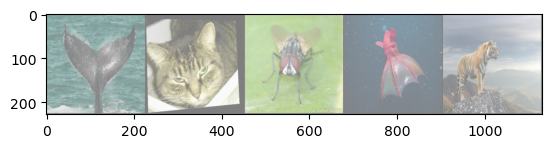

balaenoptera-musculus felis-catus musca-domestica architeuthis-dux panthera-tigris
CPU times: user 459 ms, sys: 512 ms, total: 972 ms
Wall time: 23.4 s


In [67]:
%%time

# function to show an image
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

# get some random training images
dataiter = iter(trainloader)
images, labels = next(dataiter)

# show images
imshow(torchvision.utils.make_grid(images[0:5]))
# print labels
print(' '.join(f'{class_names[labels[j]]:5s}' for j in range(5)))

### TRAINING STEP
Define a convolution neural network

In [68]:
import torch.nn as nn
import torch.nn.functional as F

class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(3, 3)
        self.conv2 = nn.Conv2d(6, 20, 5)
        self.conv3 = nn.Conv2d(20, 32, 5)
        self.fc1 = nn.Linear(1152, 300)
        self.fc2 = nn.Linear(300, 200)
        self.fc3 = nn.Linear(200, len(class_names))

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

net = Net()
net.to(device)
print(f'Trainable params: {sum(p.numel() for p in net.parameters() if p.requires_grad)}')

Trainable params: 449125


Define learning rate, loss function and optimizer

In [70]:
learning_rate = 0.005

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=learning_rate, momentum=0.9)
# optimizer = optim.Adam(net.parameters(), lr=learning_rate)

Train the network

In [71]:
%%time
epochs = 40

# Initialize an empty list to store loss values for plotting
loss_values = []
val_loss_values = []
print('Starting Training...')
for epoch in range(epochs):  # loop over the dataset multiple times
    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data[0].to(device), data[1].to(device)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        step = 200
        if i % step == step - 1:    # print after ever "step" mini-batches
            print(f'epoch({epoch + 1}/{epochs}) batch: {i + 1} loss: {running_loss / step:.3f}')
            # Append the average loss to the list for plotting
            loss_values.append(running_loss / step)
            running_loss = 0.0

    # Calculate validation loss after each epoch
    val_running_loss = 0.0
    val_correct = 0
    val_total = 0
    with torch.no_grad():
        for data in valloader:
            val_inputs, val_labels = data[0].to(device), data[1].to(device)
            val_outputs = net(val_inputs)
            val_loss = criterion(val_outputs, val_labels)
            val_running_loss += val_loss.item()
    val_loss_values.append(val_running_loss / len(valloader))
    print(f'epoch({epoch + 1}/{epochs}) Validation loss: {val_running_loss / len(valloader)}')

print('Finished Training')

Starting Training...
epoch(1/40) batch: 200 loss: 4.219
epoch(1/40) batch: 400 loss: 3.907
epoch(1/40) batch: 600 loss: 3.853
epoch(1/40) batch: 800 loss: 3.790
epoch(1/40) batch: 1000 loss: 3.694
epoch(1/40) batch: 1200 loss: 3.627
epoch(1/40) batch: 1400 loss: 3.529
epoch(1/40) batch: 1600 loss: 3.463
epoch(1/40) batch: 1800 loss: 3.343
epoch(1/40) batch: 2000 loss: 3.260
epoch(1/40) Validation loss: 3.152557322899794
epoch(2/40) batch: 200 loss: 3.138
epoch(2/40) batch: 400 loss: 3.114
epoch(2/40) batch: 600 loss: 3.043
epoch(2/40) batch: 800 loss: 2.983
epoch(2/40) batch: 1000 loss: 2.907
epoch(2/40) batch: 1200 loss: 2.870
epoch(2/40) batch: 1400 loss: 2.846
epoch(2/40) batch: 1600 loss: 2.811
epoch(2/40) batch: 1800 loss: 2.714
epoch(2/40) batch: 2000 loss: 2.677
epoch(2/40) Validation loss: 2.544197802174135
epoch(3/40) batch: 200 loss: 2.558
epoch(3/40) batch: 400 loss: 2.484
epoch(3/40) batch: 600 loss: 2.468
epoch(3/40) batch: 800 loss: 2.392
epoch(3/40) batch: 1000 loss: 2.3

In [72]:
PATH = BASE_DIR / 'models/ac_py_small.pth'
torch.save(net.state_dict(), PATH)

In [ ]:
# Plot the loss graph
train_loss_values = []
step = 10
for i in range(1, len(loss_values)):
    if i % step == step - 1:
        train_loss_values.append(loss_values[i])
        
plt.figure(figsize=(6, 6)) # size of the plot
plt.plot(train_loss_values, label='Training Loss')
plt.plot(val_loss_values, label='Validation Loss')
plt.xlabel('epochs')
plt.ylabel('Loss')
plt.title('Training Loss Over Time')
plt.legend()
custom_x_range = (0, epochs)
plt.xlim(custom_x_range)
plt.show()

### TESTING
Test the trained network on test data

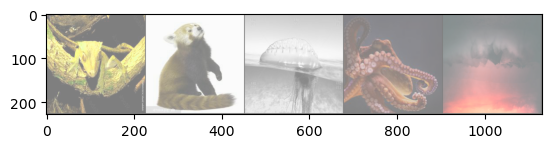

GroundTruth:  correlophus-ciliatus ailurus-fulgens physalia-physalis enteroctopus-dofleini equus-caballus
CPU times: user 673 ms, sys: 192 ms, total: 866 ms
Wall time: 13.3 s


In [75]:
%%time

dataiter = iter(testloader)
images, labels = next(dataiter)

# print images
imshow(torchvision.utils.make_grid(images[0:5]))
print('GroundTruth: ', ' '.join(f'{class_names[labels[j]]:5s}' for j in range(5)))

In [76]:
# Load the trained model
PATH = BASE_DIR / 'models/ac_py_small.pth'

net = Net()
net.load_state_dict(torch.load(PATH))

<All keys matched successfully>

Run tests on a subset of test data

In [77]:
%%time
outputs = net(images)
_, predicted = torch.max(outputs, 1)
print('Predicted: ', ' '.join(f'{class_names[predicted[j]]:5s}' for j in range(5)))

Predicted:  correlophus-ciliatus ailurus-fulgens physalia-physalis enteroctopus-dofleini equus-caballus
CPU times: user 206 ms, sys: 138 ms, total: 344 ms
Wall time: 150 ms


Run test on the entire test data

In [78]:
%%time
# Find the test loss
test_running_loss = 0.0
with torch.no_grad():
    for data in testloader:
        test_inputs, test_labels = data
        
        test_outputs = net(test_inputs)
        test_loss = criterion(test_outputs, test_labels)
        test_running_loss += test_loss.item()
print(f'Test Loss: {test_running_loss / len(testloader)}')

Test Loss: 0.4769319815499316
CPU times: user 55.8 s, sys: 10.5 s, total: 1min 6s
Wall time: 1min 30s


In [79]:
%%time
correct = 0
total = 0
# since we're not training, we don't need to calculate the gradients for our outputs
with torch.no_grad():
    for data in testloader:
        inputs, labels = data
        if inputs.size()[0] != batch_size:
            break
        # calculate outputs by running images through the network
        outputs = net(inputs)
        # the class with the highest energy is what we choose as prediction
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
print(f'Number of test images: {total}')
print(f'Number of correct predictions: {correct}')
print(f'Accuracy of the network on test images: {100 * correct // total} %')

Number of test images: 17280
Number of correct predictions: 14983
Accuracy of the network on test images: 86 %
CPU times: user 55.8 s, sys: 9.57 s, total: 1min 5s
Wall time: 1min 28s


Run test for each class

In [80]:
%%time
# prepare to count predictions for each class
correct_pred = {classname: 0 for classname in class_names}
total_pred = {classname: 0 for classname in class_names}

# again no gradients needed
with torch.no_grad():
    for data in testloader:
        inputs, labels = data
            
        outputs = net(inputs)
        _, predictions = torch.max(outputs, 1)
        # collect the correct predictions for each class
        for label, prediction in zip(labels, predictions):
            if label == prediction:
                correct_pred[class_names[label]] += 1
            total_pred[class_names[label]] += 1


# print accuracy for each class
for classname, correct_count in correct_pred.items():
    accuracy = 100 * correct_count / total_pred[classname]
    print(f'Accuracy for class: {classname:5s} is {accuracy:.1f} %')

Accuracy for class: acinonyx-jubatus is 87.2 %
Accuracy for class: agkistrodon-contortrix is 77.8 %
Accuracy for class: ailuropoda-melanoleuca is 96.9 %
Accuracy for class: ailurus-fulgens is 86.2 %
Accuracy for class: alces-alces is 87.9 %
Accuracy for class: anas-platyrhynchos is 80.4 %
Accuracy for class: apis-mellifera is 89.2 %
Accuracy for class: aptenodytes-forsteri is 83.1 %
Accuracy for class: aquila-chrysaetos is 88.3 %
Accuracy for class: ara-macao is 95.6 %
Accuracy for class: architeuthis-dux is 86.5 %
Accuracy for class: ardea-herodias is 97.3 %
Accuracy for class: balaenoptera-musculus is 85.0 %
Accuracy for class: betta-splendens is 87.5 %
Accuracy for class: bison-bison is 93.8 %
Accuracy for class: bos-gaurus is 90.2 %
Accuracy for class: bos-taurus is 82.5 %
Accuracy for class: bradypus-variegatus is 76.0 %
Accuracy for class: branta-canadensis is 94.1 %
Accuracy for class: canis-lupus is 81.5 %
Accuracy for class: canis-lupus-familiaris is 84.3 %
Accuracy for class: